In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
import math
from scipy.signal import convolve2d 
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import random

In [2]:

def enhance_brightness(img: Image.Image, scale: float) -> Image.Image:
    
    width, height = img.size
    pixels = img.load()
    
    bright_img = Image.new("RGB", (width, height))
    bright_pixels = bright_img.load()
    
    for y in range(height):
        for x in range(width):
            r, g, b = pixels[x, y]
            r = int(min(255, r * scale))
            g = int(min(255, g * scale))
            b = int(min(255, b * scale))
            bright_pixels[x, y] = (r, g, b)

    return bright_img


def getextrema(img: Image.Image):
    
    img = img.convert("RGB")
    width, height = img.size
    pixels = img.load()

    rmin, rmax = 255, 0
    gmin, gmax = 255, 0
    bmin, bmax = 255, 0

    for y in range(height):
        for x in range(width):
            r, g, b = pixels[x, y]
            rmin = min(rmin, r)
            rmax = max(rmax, r)
            gmin = min(gmin, g)
            gmax = max(gmax, g)
            bmin = min(bmin, b)
            bmax = max(bmax, b)

    return (rmin, rmax), (gmin, gmax), (bmin, bmax)

    
def convert_to_ela(image_path, quality=90, size=(224, 224)):
    
    original = image_path.convert("RGB").resize(size)
    temp_file = 'temp_ela.jpg'
    original.save(temp_file, "JPEG", quality=quality)
    
    compressed = Image.open(temp_file).convert("RGB").resize(size)
    diff = Image.new("RGB", original.size)

    width, height = original.size
    for x in range(width):
        for y in range(height):
            r1, g1, b1 = original.getpixel((x, y))
            r2, g2, b2 = compressed.getpixel((x, y))
            diff_pixel = (
                abs(r1 - r2),
                abs(g1 - g2),
                abs(b1 - b2)
            )
            diff.putpixel((x, y), diff_pixel)

    extrema = getextrema(diff)
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    diff = enhance_brightness(diff, scale)

    return diff 

    

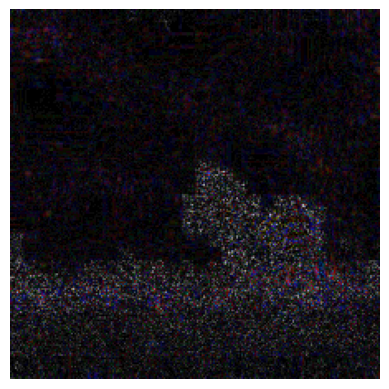

In [3]:
image = Image.open("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00001.jpg")

ela_image = convert_to_ela(image)
plt.imshow(ela_image)
plt.axis('off')  
plt.show()

In [4]:
def xu_li_img(img_path, label):
    try:
        pil_img = Image.open(img_path).convert("RGB")
        ela_img = convert_to_ela(pil_img)
        return ela_img
    except Exception as e:
        print(f"Lỗi khi xử lý {img_path}: {e}")
        return None


dataset_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2"
X_ELA = []
y = []

# Xử lý ảnh fake
fk_path = os.path.join(dataset_path, "Tp")
fk_images = [os.path.join(fk_path, f) for f in os.listdir(fk_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]
random.shuffle(fk_images)
selected_fk_images = fk_images[:5125]

for img_path in tqdm(selected_fk_images, desc="Đang xử lý ảnh giả"):
    label = 1
    result = xu_li_img(img_path, label)
    if result is not None:
        X_ELA.append(np.array(result))
        y.append(label)

# Xử lý ảnh Real 
real_path = os.path.join(dataset_path, "Au")
real_images = [os.path.join(real_path, f) for f in os.listdir(real_path)
               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]
random.shuffle(real_images)
selected_real_images = real_images[:7492]

for img_path in tqdm(selected_real_images, desc="Đang xử lý ảnh gốc"):
    label = 0
    result = xu_li_img(img_path, label)
    if result is not None:
        X_ELA.append(np.array(result))
        y.append(label)


Đang xử lý ảnh gốc: 100%|██████████| 7437/7437 [25:02<00:00,  4.95it/s]


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np


X_ela = np.array(X_ELA)
y = np.array(y)

# Chia tập train/val/test (70/15/15) với stratify theo nhãn
X_ela_train, X_ela_temp, y_train, y_temp = train_test_split(
    X_ela, y, test_size=0.3, stratify=y, random_state=42
)

X_ela_val, X_ela_test, y_val, y_test = train_test_split(
    X_ela_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# In thông tin tập dữ liệu
print(f"kích thước ELA - train: {X_ela_train.shape}")
print(f"kích thước ELA - val:   {X_ela_val.shape}")
print(f"kích thước ELA - test:  {X_ela_test.shape}")
print(f"phân bố nhãn train: {np.bincount(y_train)}")
print(f"phân bố nhãn val:   {np.bincount(y_val)}")
print(f"phân bố nhãn test:  {np.bincount(y_test)}")

# Lưu dữ liệu
np.save('/kaggle/working/X_ela_train.npy', X_ela_train)
np.save('/kaggle/working/X_ela_val.npy', X_ela_val)
np.save('/kaggle/working/X_ela_test.npy', X_ela_test)

np.save('/kaggle/working/y_train.npy', y_train)
np.save('/kaggle/working/y_val.npy', y_val)
np.save('/kaggle/working/y_test.npy', y_test)

print(" Đã lưu toàn bộ dữ liệu ELA thành công!")


kích thước ELA - train: (8792, 224, 224, 3)
kích thước ELA - val:   (1884, 224, 224, 3)
kích thước ELA - test:  (1884, 224, 224, 3)
phân bố nhãn train: [5206 3586]
phân bố nhãn val:   [1115  769]
phân bố nhãn test:  [1116  768]
 Đã lưu toàn bộ dữ liệu ELA thành công!


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score


def build_vgg16_sigmoid_finetune(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
   
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-4:]:  
        layer.trainable = True

   
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


X_train = np.load('/kaggle/working/X_ela_train.npy')
X_val   = np.load('/kaggle/working/X_ela_val.npy')
X_test  = np.load('/kaggle/working/X_ela_test.npy')

y_train = np.load('/kaggle/working/y_train.npy')
y_val   = np.load('/kaggle/working/y_val.npy')
y_test  = np.load('/kaggle/working/y_test.npy')


weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train),
                                             y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)

# Huấn luyện mô hình
model = build_vgg16_sigmoid_finetune(input_shape=(224, 224, 3))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Đánh giá mô hình 
y_pred_probs = model.predict(X_test)
thresholds = np.arange(0.3, 0.71, 0.05)

best_f1 = 0
best_t = 0.5

for t in thresholds:
    y_pred = (y_pred_probs > t).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f"Threshold {t:.2f} → F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_t = t




2025-05-12 02:49:39.723011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747018179.917887      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747018179.974417      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class weights: {0: 0.844410295812524, 1: 1.2258784160624652}


I0000 00:00:1747018195.306261      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747018195.306972      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1747018204.375503      66 service.cc:148] XLA service 0x7c28a8007c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747018204.376246      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747018204.376269      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747018204.841494      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747018219.041093      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 121s 375ms/step - accuracy: 0.6135 - loss: 0.8476 - val_accuracy: 0.6322 - val_loss: 0.6224
Epoch 2/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 305ms/step - accuracy: 0.7385 - loss: 0.5422 - val_accuracy: 0.7856 - val_loss: 0.4553
Epoch 3/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 309ms/step - accuracy: 0.8059 - loss: 0.4411 - val_accuracy: 0.8163 - val_loss: 0.4181
Epoch 4/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 83s 302ms/step - accuracy: 0.8388 - loss: 0.3712 - val_accuracy: 0.7803 - val_loss: 0.4755
Epoch 5/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 307ms/step - accuracy: 0.8698 - loss: 0.3111 - val_accuracy: 0.8360 - val_loss: 0.3988
Epoch 6/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 306ms/step - accuracy: 0.8977 - loss: 0.2415 - val_accuracy: 0.8073 - val_loss: 0.5039
Epoch 7/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 307ms/step - accuracy: 0.9156 - loss: 0.1980 - val_accuracy: 0.8227 - val_loss: 0.4723
Epoch 8/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 82s 300ms/step - accuracy: 0.9284 - loss: 0.1669 - va

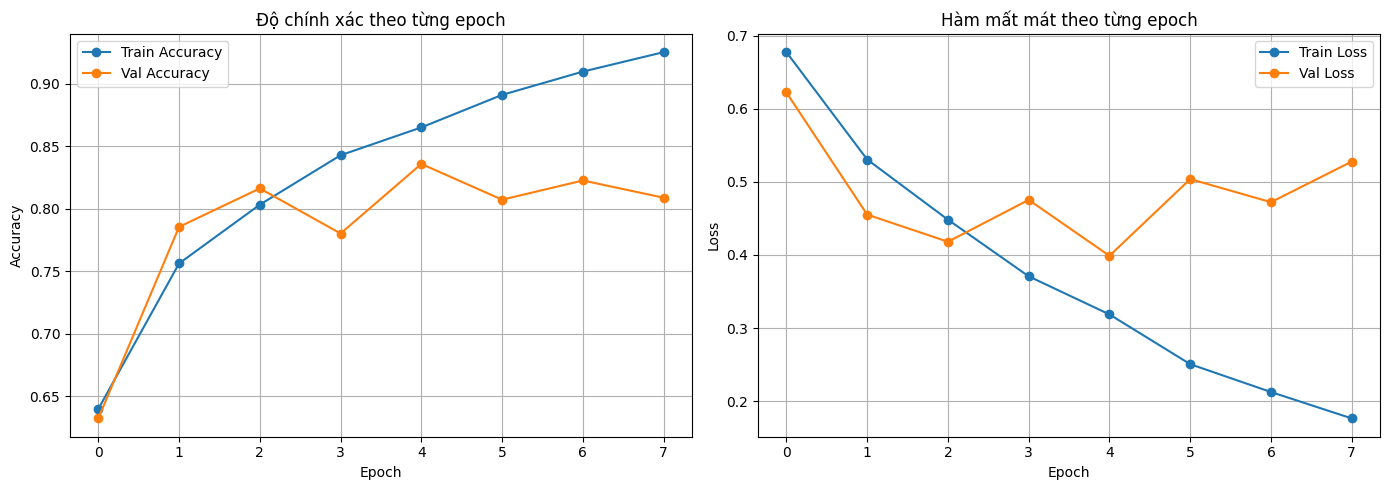

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    #biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Độ chính xác theo từng epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    #biểu đồLoss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Hàm mất mát theo từng epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

In [8]:

model.save('ela_model.h5') 


In [9]:
from tensorflow.keras.models import load_model
import json

def load_model_paras(model_path):
    model = load_model(model_path)
    return model

In [10]:
from skimage.transform import resize
from PIL import Image
import numpy as np

def predict_img(img_path, model):
    img = Image.open(img_path)
    ela = convert_to_ela(img) 
    ela = np.array(ela)
    
    ela = resize(ela, (224, 224), preserve_range=True, anti_aliasing=True)
    
    ela = ela / 255.0
    
    ela = ela.reshape(1, 224, 224, 3)

    prediction = model.predict(ela)[0][0]
    
    result = "ảnh đã chỉnh sửa!" if prediction >= 0.68 else "ảnh gốc chưa qua chính sửa!"
    

    return result


In [11]:
from PIL import Image
import numpy as np


model = load_model_paras('/kaggle/working/ela_model.h5')
img_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00034.jpg'
result = predict_img(img_path, model)
print(f"Ảnh này là: {result}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Ảnh này là: ảnh đã chỉnh sửa!
